## Fitting dynamical models with priors which are conditioned on functional anchors

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import itertools
import math

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondLowRankMatrixDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn

from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters go here

In [3]:
n_neurons = 100
n_modes = 1
n_smps = 2000
neural_noise_std = .2 # Amount of noise we add to neural activity

## Here we define functions for visualization

In [4]:
def visualize_mode_mean(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()
    
def visualize_low_rank_matrix_modes(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    l_dists = d.l_mode_dists
    r_dists = d.r_mode_dists
    
    n_modes = len(l_dists)
    
    plt.figure()
    
    for m_i in range(n_modes):
        
        # Plot r modes in top row
        plt.subplot(2, n_modes, m_i+1)
        visualize_mode_mean(r_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        
        # Plot l modes in second row
        plt.subplot(2, n_modes, m_i+1 + n_modes)
        visualize_mode_mean(l_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        

## Define the likelihood model we will use

In [5]:
class SubjectModel(torch.nn.Module):
    
    def __init__(self, d_x:int):
        """ Creates a SubjectModel object.
        
        Args:
            n: the dimensionality of x (which is the data we predict from)
        """
        
        super().__init__()
         
        self.d_x = d_x
        self.std = ConstantBoundedFcn(lower_bound=.01*np.ones(d_x), upper_bound=5*np.ones(d_x), init_value=np.ones(d_x))
        
    def forward(self, x: torch.Tensor, w: torch.Tensor):
        
        return cond_mn(x, w)
        
    def cond_mn(self, x: torch.Tensor, w: torch.Tensor):
        """ Computes mean given x and w.
        
        Args:
            x: neural data of shape n_smps*d_x
            
            w: weight matrix of shape d_y*d_x
            
        Returns:
            mn: mean of shape n_smps*d_y
        
        """
        return torch.matmul(x, w.t())
    
    def cond_ll(self, x: torch.Tensor, y: torch.Tensor, w: torch.Tensor):
        """ Computes conditional likelihood of y, given x and w.
        
        Args:
            x: neural data to condition on of shape n_smps*d_x
            
            y: neural data to predict of shape n_smps*d_y
            
            w: weight matrix of shape d_y*d_x
            
        Returns:
            ll: conditional likelihood of each sample, of shape n_smps
        """
        
        if len(x.shape) == 1:
            raise(NotImplementedError('Code has not been tested with a single sample. May need to check that it still computes correctly.'))
        
        d_y = y.shape[1]
        
        mn = self.cond_mn(x, w)
        std = self.std(mn)
           
        delta = y - mn
        delta_div = delta/std
        dist_sq = torch.sum(delta_div**2,1)
        
        
        ll = -.5*dist_sq
        ll -= torch.sum(torch.log(std), 1)
        ll -= .5*d_y*torch.log(torch.tensor([math.pi]))
        
        return ll

## Generate neuron properties

In [6]:
neuron_props = torch.zeros(n_neurons, 2).uniform_()

## Define true conditional prior on weights matrix

In [165]:
# Spike and slab modes

n_nodes = 2

p_l_mode_dists = [None]*n_modes
p_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    p_l_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=10.0, ctr_std_init=.5,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
    p_l_spike_d = CondBernoulliDistribution(p_l_spike_log_prob_fcn)

    p_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_l_slab_mn_fcn[4].weight.data = 10*p_l_slab_mn_fcn[4].weight.data

    p_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_l_slab_d = CondGaussianDistribution(mn_f=p_l_slab_mn_fcn, std_f=p_l_slab_std_fcn)


    p_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_l_spike_d, slab_d=p_l_slab_d)
    
    
    # Setup r mode 
    p_r_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=1.0, ctr_std_init=.5,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
    p_r_spike_d = CondBernoulliDistribution(p_r_spike_log_prob_fcn)

    p_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_r_slab_mn_fcn[4].weight.data = 10*p_r_slab_mn_fcn[4].weight.data

    p_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_r_slab_d = CondGaussianDistribution(mn_f=p_r_slab_mn_fcn, std_f=p_r_slab_std_fcn)


    p_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_r_spike_d, slab_d=p_r_slab_d)
    

p = CondLowRankMatrixDistribution(l_mode_dists=p_l_mode_dists, r_mode_dists=p_r_mode_dists)

## Sample from prior on weight matrix to get true modes of the weight matrix for the subject

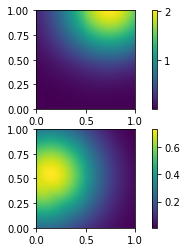

In [166]:
visualize_low_rank_matrix_modes(p)

In [167]:
with torch.no_grad():
    smp = p.sample(neuron_props, neuron_props)
    w = p.form_matrix(smp)

In [168]:
with torch.no_grad():
    smp = p.sample(neuron_props, neuron_props)
    w1 = p.form_matrix(smp)

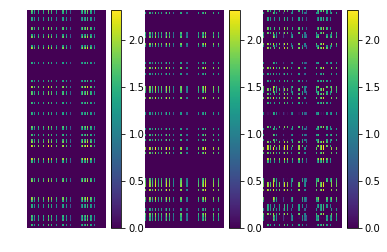

In [169]:
w_n = w.detach().numpy()
w1_n = w1.detach().numpy()
cmp_n_mats([w_n, w1_n, np.abs(w_n - w1_n)], show_colorbars=True)

## Generate neural activity

In [170]:
with torch.no_grad():
    x = torch.randn([n_smps, n_neurons])
    y_mn = torch.matmul(x, w.t())
    y_noise = torch.randn([n_smps, n_neurons])*neural_noise_std
    y = y_mn #+ y_noise

## Initialize conditional prior on weights matrix we will fit

In [171]:
# Spike and slab modes

q_l_mode_dists = [None]*n_modes
q_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    q_l_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=10.0, ctr_std_init=.5,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
    q_l_spike_d = CondBernoulliDistribution(q_l_spike_log_prob_fcn)

    q_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))

    q_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.25))

    q_l_slab_d = CondGaussianDistribution(mn_f=q_l_slab_mn_fcn, std_f=q_l_slab_std_fcn)


    #q_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=q_l_spike_d, slab_d=q_l_slab_d)
    q_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_l_mode_dists[m_i].spike_d, slab_d=q_l_slab_d)
    
    # Setup r mode 
    q_r_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=10.0, ctr_std_init=.2,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
    q_r_spike_d = CondBernoulliDistribution(q_r_spike_log_prob_fcn)

    q_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))

    q_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.25))

    q_r_slab_d = CondGaussianDistribution(mn_f=q_r_slab_mn_fcn, std_f=q_r_slab_std_fcn)


    #q_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=q_r_spike_d, slab_d=q_r_slab_d)
    q_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_r_mode_dists[m_i].spike_d, slab_d=q_r_slab_d)

q = CondLowRankMatrixDistribution(l_mode_dists=q_l_mode_dists, r_mode_dists=q_r_mode_dists)

## Define a function we will use to enforce constraints

In [172]:
def enforce_constraints():
    for m_i in range(n_modes):
        
        l_ctr = q.l_mode_dists[m_i].spike_d.log_prob_fcn.ctr.data.numpy()
        l_ctr[0] = np.max([np.min([l_ctr[0], .95]), .05])    
        l_ctr[1] = np.max([np.min([l_ctr[1], .95]), .05]) 
        q.l_mode_dists[m_i].spike_d.log_prob_fcn.ctr.data = torch.from_numpy(l_ctr)
        
        r_ctr = q.r_mode_dists[m_i].spike_d.log_prob_fcn.ctr.data.numpy()
        r_ctr[0] = np.max([np.min([r_ctr[0], .95]), .05])    
        r_ctr[1] = np.max([np.min([r_ctr[1], .95]), .05]) 
        q.r_mode_dists[m_i].spike_d.log_prob_fcn.ctr.data = torch.from_numpy(r_ctr)

## Perform fitting

In [173]:
s = SubjectModel(n_neurons)

In [174]:
r_params = list(q.r_params())
r_params = list(itertools.chain(r_params, s.parameters()))

s_params = list(q.s_params())

r_optim = torch.optim.Adam(r_params)
s_optim = torch.optim.Adam(s_params)

In [175]:
n_its = 4000
update_int = 100

for i in range(n_its):
    # Don't need to calculate gradients for s_params yet
    for s_p in s_params:
        s_p.requires_grad = False
    
    # Sample q
    smp_i = q.sample(neuron_props, neuron_props)
    w_i = q.form_matrix(smp_i)
    s_l_i = smp_i[0]
    s_r_i = smp_i[1]
    
    # Calculate gradients we can use the reparamaterization trick for
    r_optim.zero_grad()
    nll = -1*torch.sum(s.cond_ll(x, y, w_i))
    q_log_prob_l, q_log_prob_r = q.log_prob(neuron_props, neuron_props, smp_i[0], smp_i[1])
    p_log_prob_l, p_log_prob_r = p.log_prob(neuron_props, neuron_props, smp_i[0], smp_i[1])
    kl_l = q_log_prob_l - p_log_prob_l
    kl_r = q_log_prob_r - p_log_prob_r
    
    elbo = nll #+ torch.sum(kl_l) + torch.sum(kl_r)
    elbo.backward(retain_graph=True)
    
    # Set things up to calculate gradients for parameters we need score function for
    for s_p in s_params:
        s_p.requires_grad = True
    for r_p in r_params:
        r_p.requires_grad = False
        
    with torch.no_grad():
        ls_l = nll + kl_l
        ls_r = nll + kl_r
        
    s_optim.zero_grad()
    o_s = 0
    for m_i in range(n_modes):
        o_s += torch.sum(ls_l[:,m_i]*q.l_mode_dists[m_i].log_prob(neuron_props, s_l_i[m_i]))
        o_s += torch.sum(ls_r[:,m_i]*q.r_mode_dists[m_i].log_prob(neuron_props, s_r_i[m_i]))

    o_s.backward()
        
    for r_p in r_params:
        r_p.requires_grad = True   
    
    # Actually update parameters here
    r_optim.step()
    #s_optim.step()
    
    # Enforce constraints
    enforce_constraints()
    
    # Update parameters 
    if i % update_int == 0:
        elbo_r = elbo.detach().numpy()
        o_s_r = o_s.detach().numpy()
        print('It: ' + str(i) + ', elbo: ' + str(elbo_r) + ' o_s: ' + str(o_s))
    

It: 0, elbo: 1818758.1 o_s: tensor(-1.1911e+08, grad_fn=<AddBackward0>)
It: 100, elbo: 1431496.9 o_s: tensor(-80590976., grad_fn=<AddBackward0>)
It: 200, elbo: 1095669.6 o_s: tensor(-46777340., grad_fn=<AddBackward0>)
It: 300, elbo: 983636.75 o_s: tensor(-40528208., grad_fn=<AddBackward0>)
It: 400, elbo: 820094.6 o_s: tensor(-29869176., grad_fn=<AddBackward0>)
It: 500, elbo: 757128.44 o_s: tensor(-27296480., grad_fn=<AddBackward0>)
It: 600, elbo: 647100.25 o_s: tensor(-21386922., grad_fn=<AddBackward0>)
It: 700, elbo: 617778.6 o_s: tensor(-21764644., grad_fn=<AddBackward0>)
It: 800, elbo: 515452.0 o_s: tensor(-9876226., grad_fn=<AddBackward0>)
It: 900, elbo: 489863.28 o_s: tensor(-8724099., grad_fn=<AddBackward0>)
It: 1000, elbo: 459557.44 o_s: tensor(-9936170., grad_fn=<AddBackward0>)
It: 1100, elbo: 400800.62 o_s: tensor(-4872773., grad_fn=<AddBackward0>)
It: 1200, elbo: 381097.34 o_s: tensor(-5319146., grad_fn=<AddBackward0>)
It: 1300, elbo: 355642.0 o_s: tensor(-7969316.5000, grad_

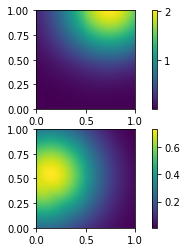

In [176]:
visualize_low_rank_matrix_modes(p)

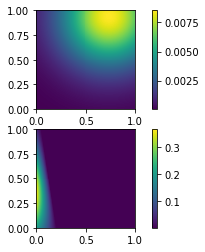

In [177]:
visualize_low_rank_matrix_modes(q)

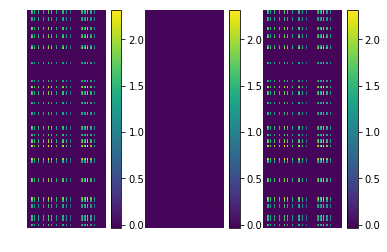

In [178]:
w_i_n = w_i.detach().numpy()
cmp_n_mats([w_n, w_i_n, np.abs(w_n - w_i_n)], show_colorbars=True)

In [179]:
smp_i = q.sample(neuron_props, neuron_props)
w_i = q.form_matrix(smp_i)

In [ ]:
s.std(neuron_props)

In [ ]:
q.l_mode_dists[0].slab_d.std_f(neuron_props)